##### Importing the necessary libraries

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

sns.set_style('darkgrid')
%matplotlib inline

##### Importing the Dataset

In [37]:
train_df = pd.read_csv('train_IxoE5JN.csv')
test_df = pd.read_csv('test_WudNWDM.csv')

##### Data Pre-Processing & EDA

In [38]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
train_df = train_df.rename(columns = {'DATE':'datetime'})
train_df = train_df.set_index('datetime')
train_df

,row_id,energy
datetime,,
2008-03-01 00:00:00,1,1259.985563
2008-03-01 01:00:00,2,1095.541500
2008-03-01 02:00:00,3,1056.247500
2008-03-01 03:00:00,4,1034.742000
2008-03-01 04:00:00,5,1026.334500
...,...,...
2018-12-31 19:00:00,94988,2528.446800
2018-12-31 20:00:00,94989,2461.883600
2018-12-31 21:00:00,94990,2365.994400


In [39]:
train_df = train_df.drop(['row_id'],axis=1)

In [40]:
train_df.head()

,energy
datetime,
2008-03-01 00:00:00,1259.985563
2008-03-01 01:00:00,1095.541500
2008-03-01 02:00:00,1056.247500
2008-03-01 03:00:00,1034.742000
2008-03-01 04:00:00,1026.334500


In [41]:
train_df.describe()

,energy
count,93092.000000
mean,1702.995014
std,369.322103
min,866.388600
25%,1431.541100
50%,1654.465800
75%,1935.993450
max,3374.399600


In [42]:
train_df.isna().sum()

energy    1900
dtype: int64

In [43]:
def describe_data(df):
    print("Data Types:")
    print(df.dtypes)
    print("Rows and Columns:")
    print(df.shape)
    print("Column Names:")
    print(df.columns)
    print("Null Values:")
    print(df.apply(lambda x: sum(x.isnull()) / len(df)))
describe_data(train_df)

Data Types:
energy    float64
dtype: object
Rows and Columns:
(94992, 1)
Column Names:
Index(['energy'], dtype='object')
Null Values:
energy    0.020002
dtype: float64


In [44]:
train_df.isnull().sum()

energy    1900
dtype: int64

In [45]:
train_df['energy'].fillna(int(train_df['energy'].mean()), inplace=True)

In [46]:
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns

In [47]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [48]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [49]:
train_df.describe(include='all')

,energy
count,94992.000000
mean,1702.975112
std,365.609902
min,866.388600
25%,1436.432500
50%,1664.625600
75%,1930.196675
max,3374.399600


In [50]:
train_df[train_df.isnull().any(axis=1)]

,energy
datetime,


In [51]:
train_df.corr()

,energy
energy,1.0


In [52]:
corr = train_df.corr(method='pearson')
print("Correlation of the Dataset:",corr)

Correlation of the Dataset:         energy
energy     1.0


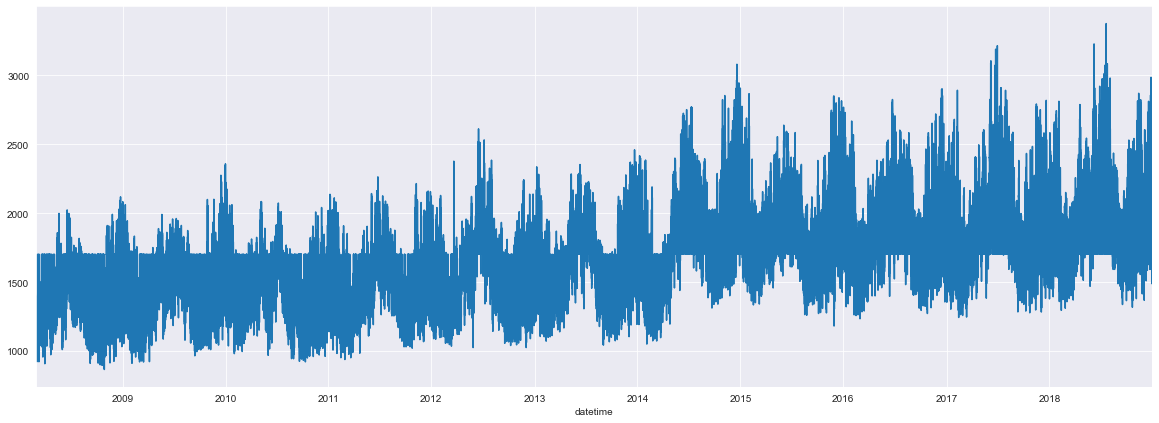

In [53]:
plt.figure(figsize = (20,7))
train_df['energy'].plot(kind = 'line')
plt.show()

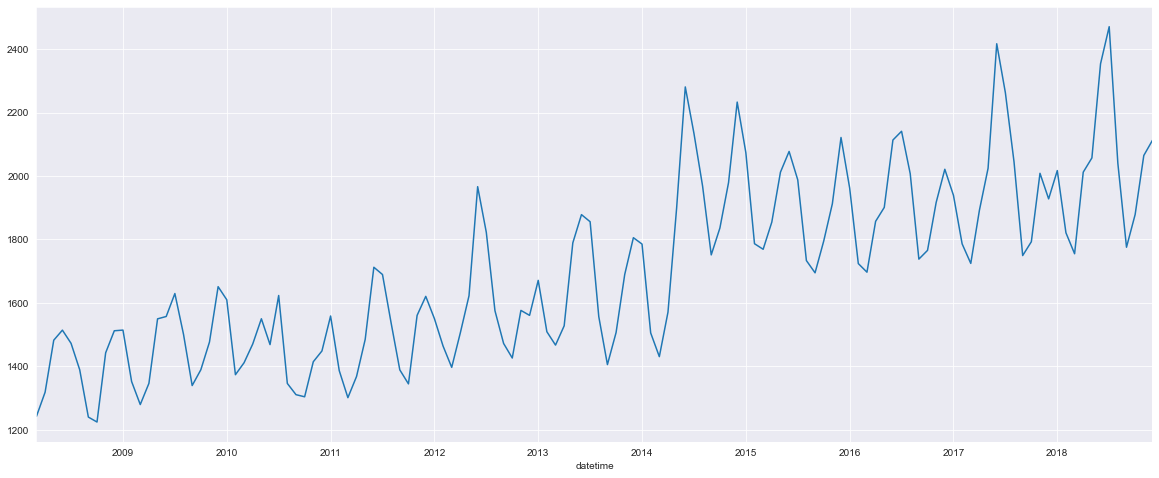

In [54]:
plt.figure(figsize = (20,8))
train_df['2008':'2018'].resample('m').mean()['energy'].plot(kind = 'line')
plt.show()

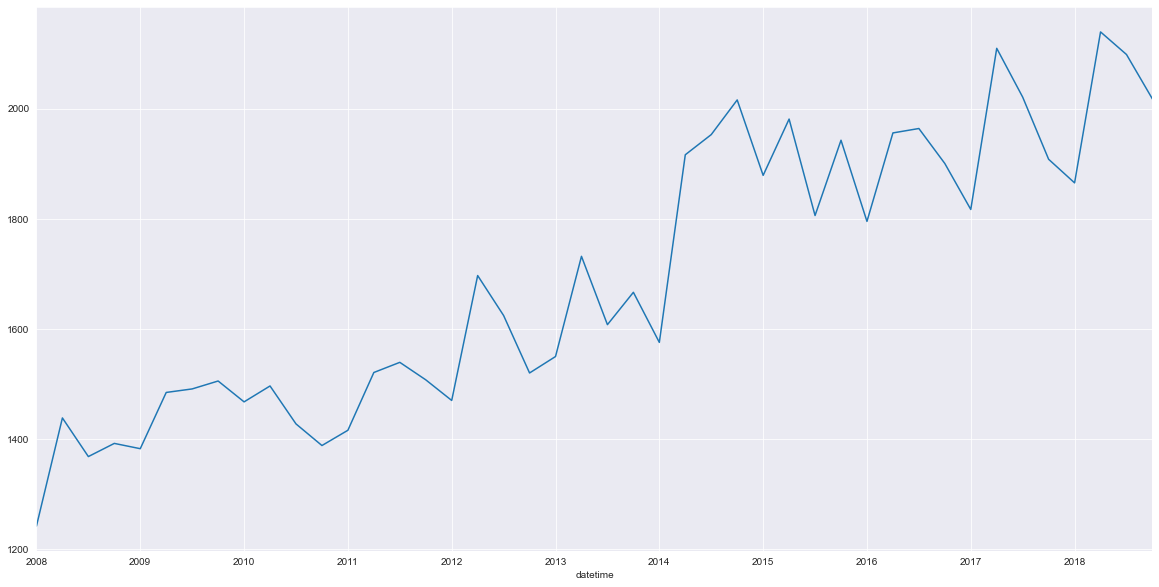

In [55]:
plt.figure(figsize = (20,10))
train_df['2008':'2018'].resample('q').mean()['energy'].plot(kind = 'line')
plt.show()

In [56]:
from statsmodels.tsa.stattools import adfuller,kpss
adftest = adfuller(train_df['energy'])
adftest

(-9.779746669629551,
 6.783205657421433e-17,
 67,
 94924,
 {'1%': -3.4304188917117377,
  '5%': -2.8615704490393217,
  '10%': -2.5667862069612752},
 1079838.321200942)

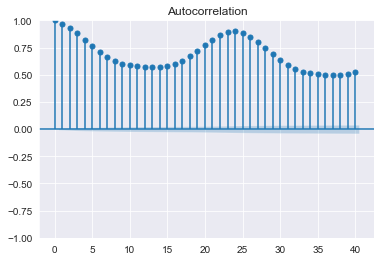

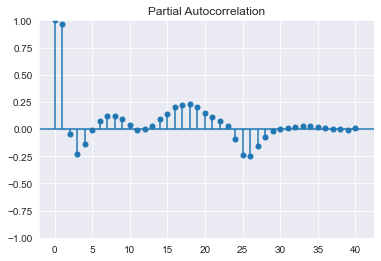

In [57]:
acf = plot_acf(train_df,lags=40)
pacf = plot_pacf(train_df,lags=40, method='ols')

In [58]:
temp = pd.DataFrame(np.log(train_df['energy']))

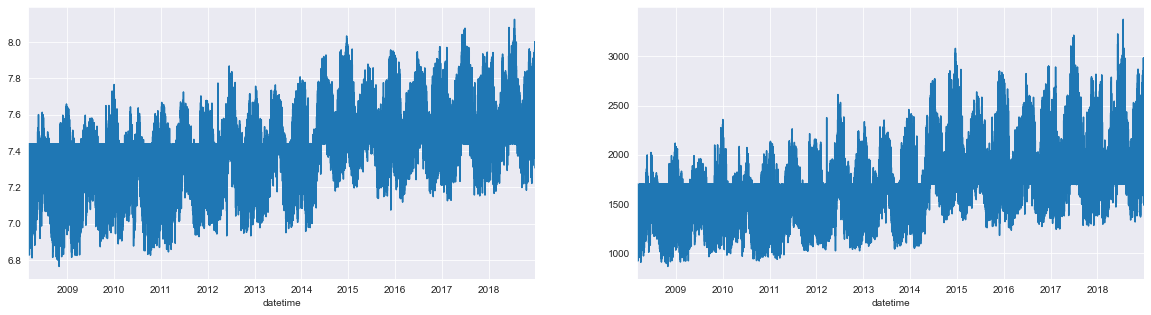

In [60]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
temp['energy'].plot(kind = 'line')
plt.subplot(1,2,2)
train_df['energy'].plot(kind = 'line')
plt.show()

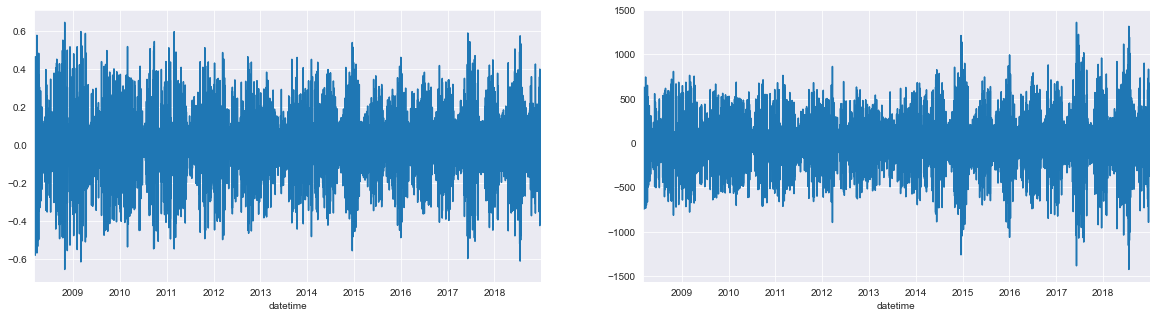

In [61]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
temp['energy'].diff(1).dropna().plot()
plt.subplot(1,2,2)
train_df['energy'].diff(1).dropna().plot()
plt.show()

In [62]:
kptest = kpss(temp['energy'].diff(1).dropna(),'c')
kptest

C:\Users\Shobhandeb\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.011969745050167641,
 0.1,
 2088,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

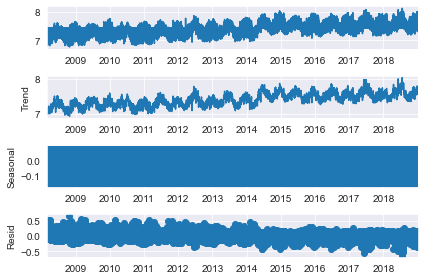

In [63]:
add_plot = sm.tsa.seasonal_decompose(temp,model = 'additive')
add_plot = add_plot.plot()

In [64]:
!pip install -q pmdarima

In [65]:
import pmdarima as pm

model = pm.auto_arima(train_df, seasonal = True, d = 1, D = 1,m = 4,test='adf',error_action='ignore',  
                           suppress_warnings=True,
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[4]             : AIC=inf, Time=293.31 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=1199372.473, Time=3.49 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=1181308.574, Time=20.62 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=27.92 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=1199374.223, Time=2.81 sec


MemoryError: Unable to allocate 142. MiB for an array with shape (14, 14, 94992) and data type float64

In [ ]:
model.summary()

In [ ]:
output = model.plot_diagnostics()

In [ ]:
from sklearn.model_selection import train_test_split
X = train_df.drop(['energy','datetime'], axis=1)
y = train_df['energy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [ ]:
lr.fit(X_train,y_train)

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
lr.fit(X_train, y_train)
print("model score: %.3f" % lr.score(X_test, y_test))

In [ ]:
print(lr.intercept_)

In [ ]:
from sklearn.metrics import r2_score
R2_score=R2_score=r2_score(y_test,y_pred)
print(R2_score)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

score = explained_variance_score(y_test, y_pred)
mae = mean_absolute_error(y_pred, y_test)

print("Score:", score)
print("Mean Absolute Error:", mae)

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared = False)
print("RMSE Score:", rmse)

In [ ]:
test_no_id = test_df.drop('datetime', axis=1)

In [ ]:
test_predictions = lr.predict(test_no_id)

In [ ]:
row_id = test_df['row_id']
submission_df_1 = pd.DataFrame({
                  "row_id": row_id, 
                  "energy": test_predictions})

In [ ]:
submission_df_1.to_csv('submission_1.csv', index=False)